<a href="https://colab.research.google.com/github/takeru0208/sample_rnn/blob/develop/sample_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
def sin2p(x, t=100):
    return np.sin(2.0 * np.pi * x / t) # sin(2πx/t) t = 周期
 
def sindata(t=100, cycle=2):
    x = np.arange(0, cycle*t) # 0 から cycle * t 未満の数
    return sin2p(x)

def noisy(Y, noise_range=(-0.05, 0.05)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise


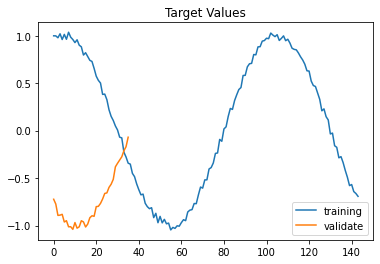

In [2]:

from sklearn.model_selection import train_test_split
 
np.random.seed(0)
 
rawdata = noisy(sindata(100,2), (-0.05, 0.05)) # 2周期分のノイズあり sin 波データを生成
inputlen = 20 # 1入力データはデータ 20 個としました
 
 # i~i+19のデータをRNNに与え、i+20のデータを予測する。
input=[]
target=[]
for i in range(0, len(rawdata) - inputlen):  # range(0, 180)   0 .. 179 の 180回実行
    input.append( rawdata[i:i+inputlen] )  # [i:i+20] のスライスで i から i+19 の20個を入力データに追加
    target.append( rawdata[i+inputlen] )  # [i+20] がその直前までのデータ群 [i:i+20] の正解値となるのでターゲットに追加

# numpy の3次元配列に変換
X = np.array(input).reshape(len(input), inputlen, 1) # 入力データ (180, 20, 1)
Y = np.array(target).reshape(len(input), 1) # ターゲット (180, 1)
 
# トレーニングと評価用にデータを 8:2 に分割します。デフォルトがシャッフルなのでしないように
x, val_x, y, val_y = train_test_split(X, Y, test_size=int(len(X) * 0.2), shuffle=False)
 
# 訓練データの正解値 y と評価用データの正解値 val_y のグラフ
plt.plot(y, label="training")
plt.plot(val_y, label="validate")
plt.title('Target Values')
plt.legend()
plt.show()


In [6]:
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Activation
from keras.initializers import VarianceScaling
n_in = 1
n_hidden = 20
n_out = 1
epochs = 10
batch_size = 10
 
model=Sequential()
model.add(SimpleRNN(n_hidden, input_shape=(inputlen, n_in), kernel_initializer='random_uniform'))
model.add(Dense(n_out, kernel_initializer='random_uniform'))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999))
model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y))


Train on 144 samples, validate on 36 samples
Epoch 1/10
144/144 [==============================] - 0s 3ms/step - loss: 0.1839 - val_loss: 0.0400
Epoch 2/10
144/144 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0117
Epoch 3/10
144/144 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0040
Epoch 4/10
144/144 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 5/10
144/144 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 6/10
144/144 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/10
144/144 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 8/10
144/144 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 9/10
144/144 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/10
144/144 [==============================] - 

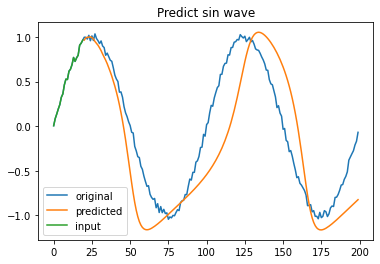

In [7]:
# 本来は評価データを使うべきですが、グラフの見栄え的に元データの左端を与えて
# 右側を予測させたかったので訓練データ x の先頭を与えました
 
in_ = x[:1] # x の先頭 (1,20,1) 配列
 
# グラフで予測データ（オレンジ）が入力データ（緑）の後に来るように
# 予測データの先頭に None を20個入れてあります
 
predicted = [None for _ in range(inputlen)] 
 
for _ in range(len(rawdata) - inputlen):
    out_ = model.predict(in_) # 予測した値 out_ は (1,1) 配列
     
    # in_ を (20,1) 配列に変換し、先頭1個をスライスして削り、末尾に out_ を足す。
    # 最後に再度 (1,20,1) 配列に変換して、全体を次の in_ にする
    in_ = np.concatenate( (in_.reshape(inputlen, n_in)[1:], out_), axis=0 ).reshape(1, inputlen, n_in)
     
    # out_ は (1,1) 配列なので任意の長さの一次元配列に変換する reshape(-1) をかけてから予測データに追加
    predicted.append(out_.reshape(-1))
 
plt.title('Predict sin wave')   
plt.plot(rawdata, label="original")
plt.plot(predicted, label="predicted")
plt.plot(x[0], label="input")
plt.legend()
plt.show()
